In [1]:
import scvi
import os
import tempfile
import scanpy as sc
import scarches as sca
import seaborn as sns
import torch
from rich import print
import numpy as np
import matplotlib.pyplot as plt

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [32]:
scvi.settings.seed = 1100110011
torch.set_float32_matmul_precision('high')

[rank: 0] Seed set to 1100110011


In [66]:
ref_adata = sc.read("/vast/scratch/users/moore.z/pdo_compar/data/intermed/snrnaseq/couturier.h5ad")
ref_adata

AnnData object with n_obs × n_vars = 24029 × 33694
    obs: 'Sample', 'Barcode', 'cluster', 'sb', 'sizeFactor'
    var: 'ID', 'Symbol', 'NA'
    uns: 'Samples', 'Samples.1', 'Samples.10', 'Samples.11', 'Samples.12', 'Samples.13', 'Samples.2', 'Samples.3', 'Samples.4', 'Samples.5', 'Samples.6', 'Samples.7', 'Samples.8', 'Samples.9', 'X_name'
    layers: 'logcounts'

In [67]:
import scipy 
ref_adata.X = scipy.sparse.csr_matrix(ref_adata.X)

In [68]:
ref_adata_full = ref_adata.copy()

In [69]:
ref_adata.layers["counts"] = ref_adata.X.copy()
# sc.pp.log1p(ref_adata)

In [70]:
sc.pp.highly_variable_genes(
    adata = ref_adata, 
    flavor = "seurat_v3",
    n_top_genes = 500, 
    batch_key = "cluster",
    subset = True
)

In [71]:
ref_adata

AnnData object with n_obs × n_vars = 24029 × 500
    obs: 'Sample', 'Barcode', 'cluster', 'sb', 'sizeFactor'
    var: 'ID', 'Symbol', 'NA', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Samples', 'Samples.1', 'Samples.10', 'Samples.11', 'Samples.12', 'Samples.13', 'Samples.2', 'Samples.3', 'Samples.4', 'Samples.5', 'Samples.6', 'Samples.7', 'Samples.8', 'Samples.9', 'X_name', 'hvg'
    layers: 'logcounts', 'counts'

In [72]:
# integration with scVI
scvi.model.SCVI.setup_anndata(
    adata = ref_adata, 
    batch_key = "cluster",
    categorical_covariate_keys = ["Sample"]
)
# create model
scvi_model = scvi.model.SCVI(
    adata = ref_adata,
    n_hidden = 128,
    n_latent = 50,
    dispersion = "gene"
)
# train model
# scvi.settings.dl_num_workers = 15
scvi_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 496/1000:  50%|████▉     | 495/1000 [09:36<09:41,  1.15s/it, v_num=1, train_loss_step=330, train_loss_epoch=320]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


<Axes: xlabel='epoch'>

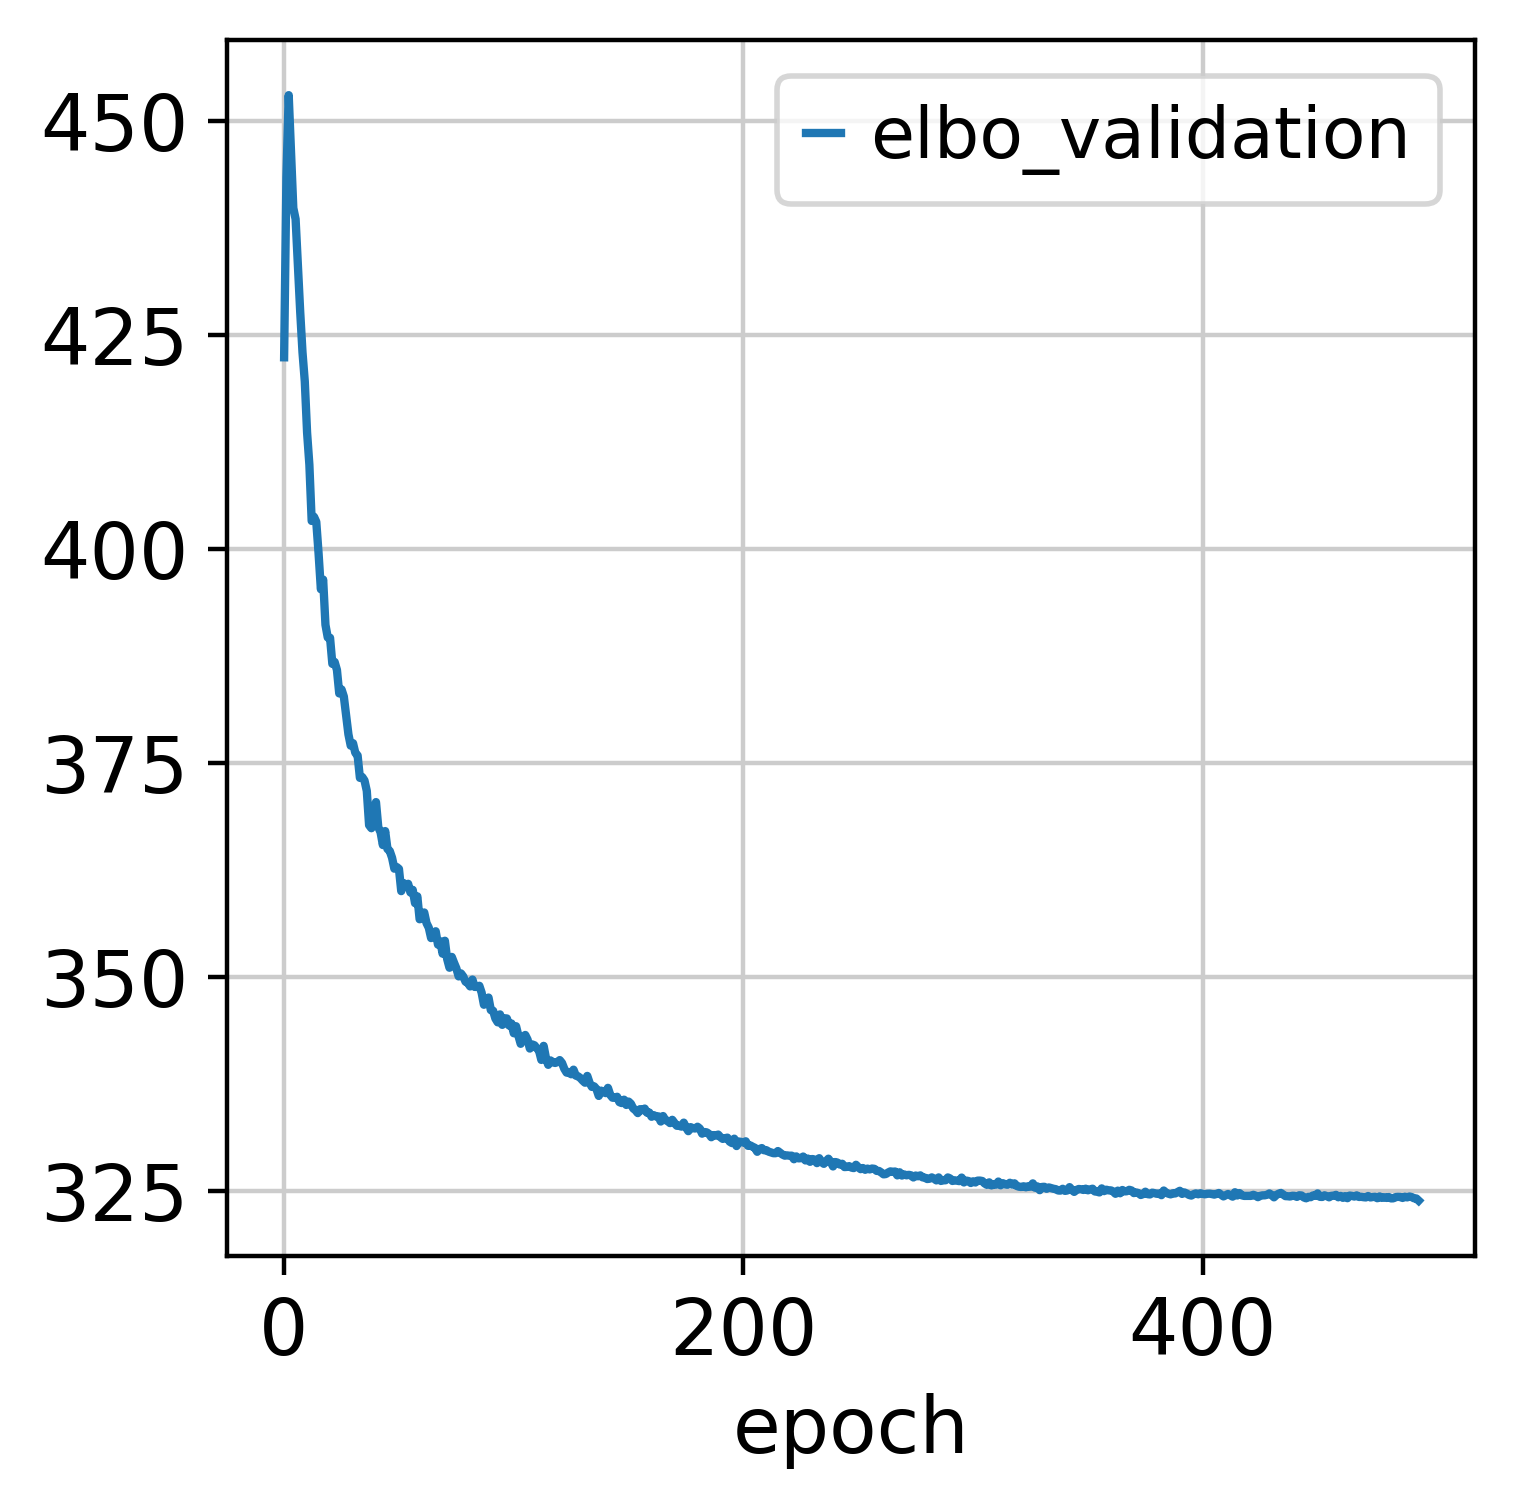

In [73]:
scvi_model.history["elbo_validation"].plot()

In [74]:
SCVI_LATENT_KEY = "X_scVI"
ref_adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation()

In [76]:
sc.pp.neighbors(
    adata = ref_adata, 
    use_rep = SCVI_LATENT_KEY, 
    # n_neighbors = 10,
    # n_pcs = 50
)
sc.tl.leiden(
    ref_adata,
    flavor = "igraph",
    # resolution = 1,
    # n_iterations = 10
)

In [77]:
SCVI_MDE_KEY = "X_scVI_MDE"
ref_adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(ref_adata.obsm[SCVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


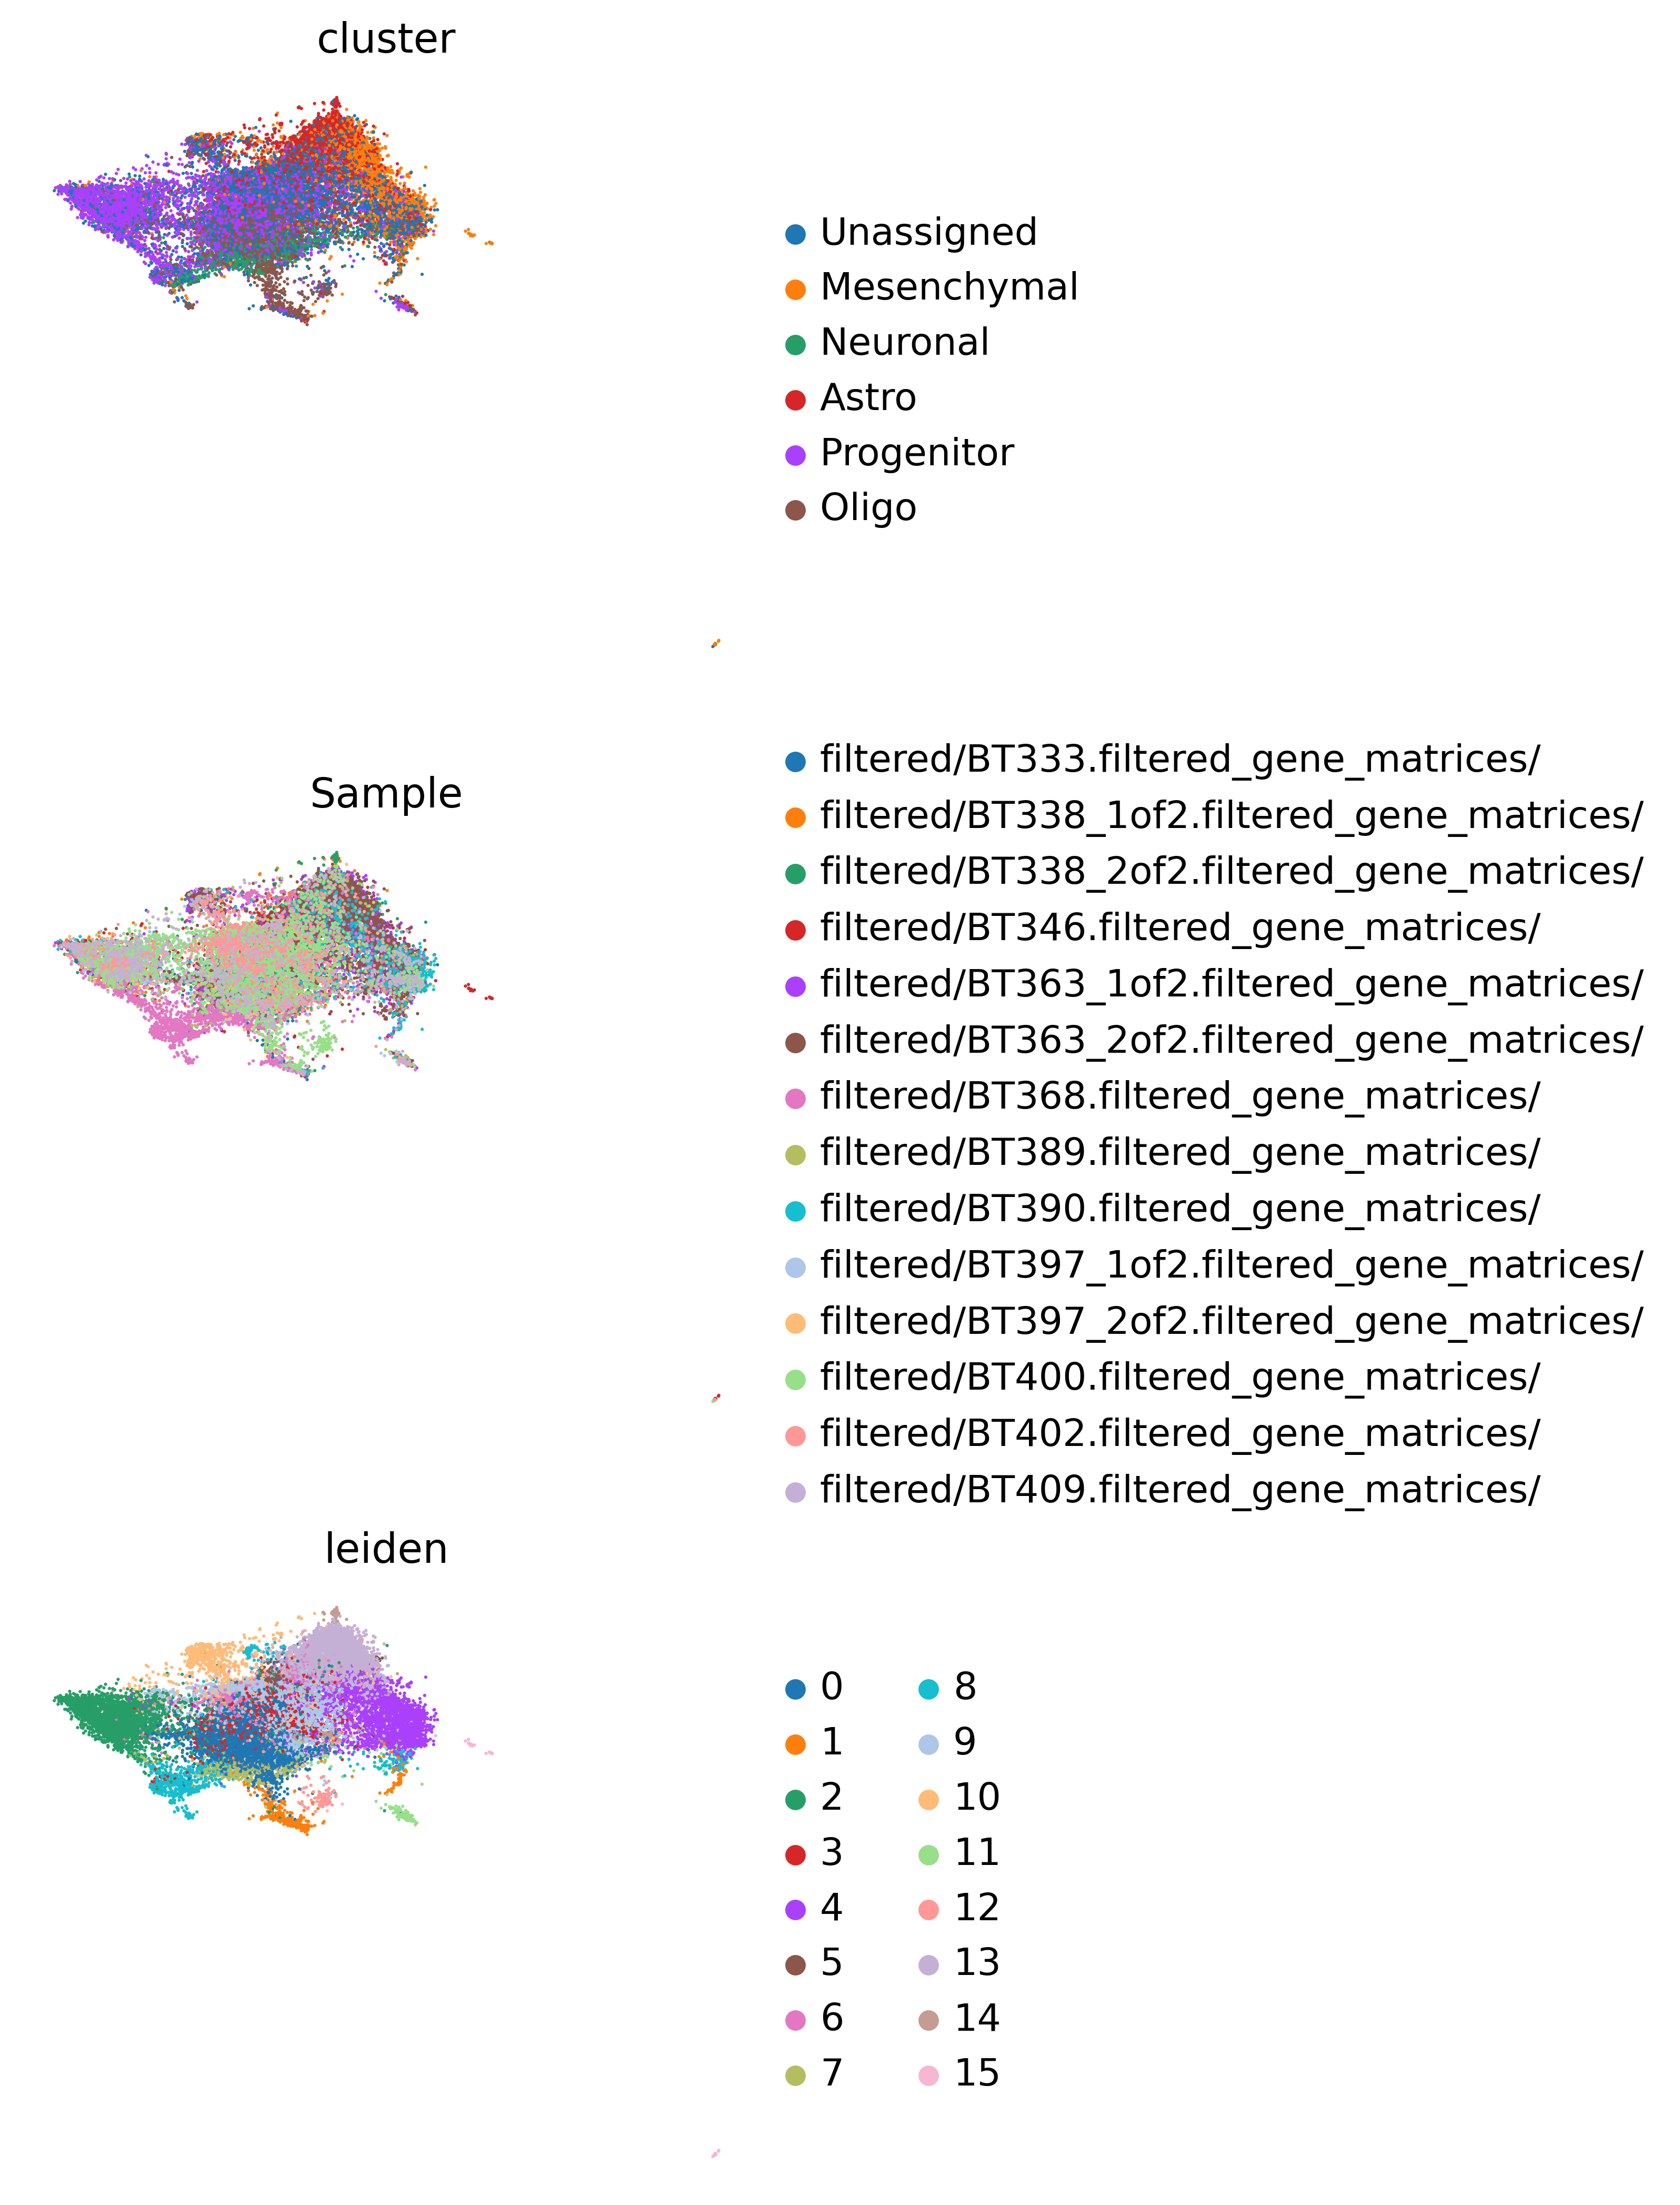

In [78]:
sc.pl.embedding(
    adata = ref_adata,
    basis = SCVI_MDE_KEY,
    color = ["cluster", "Sample", "leiden"],
    # legend_loc = "on data",
    frameon = False,
    ncols = 1
)

In [18]:
SCANVI_LABELS_KEY = "labels_scanvi"

ref_adata.obs[SCANVI_LABELS_KEY] = ref_adata.obs["cluster"].values

In [19]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    unlabeled_category = "unknown",
    labels_key = SCANVI_LABELS_KEY,
)

In [20]:
scanvi_model.train(
    max_epochs = 1000, 
    early_stopping = True
)

INFO     Training for 1000 epochs.                                                                                 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 302/1000:  30%|███       | 301/1000 [14:41<34:19,  2.95s/it, v_num=1, train_loss_step=1.84e+3, train_loss_epoch=1.79e+3]

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


<Axes: xlabel='epoch'>

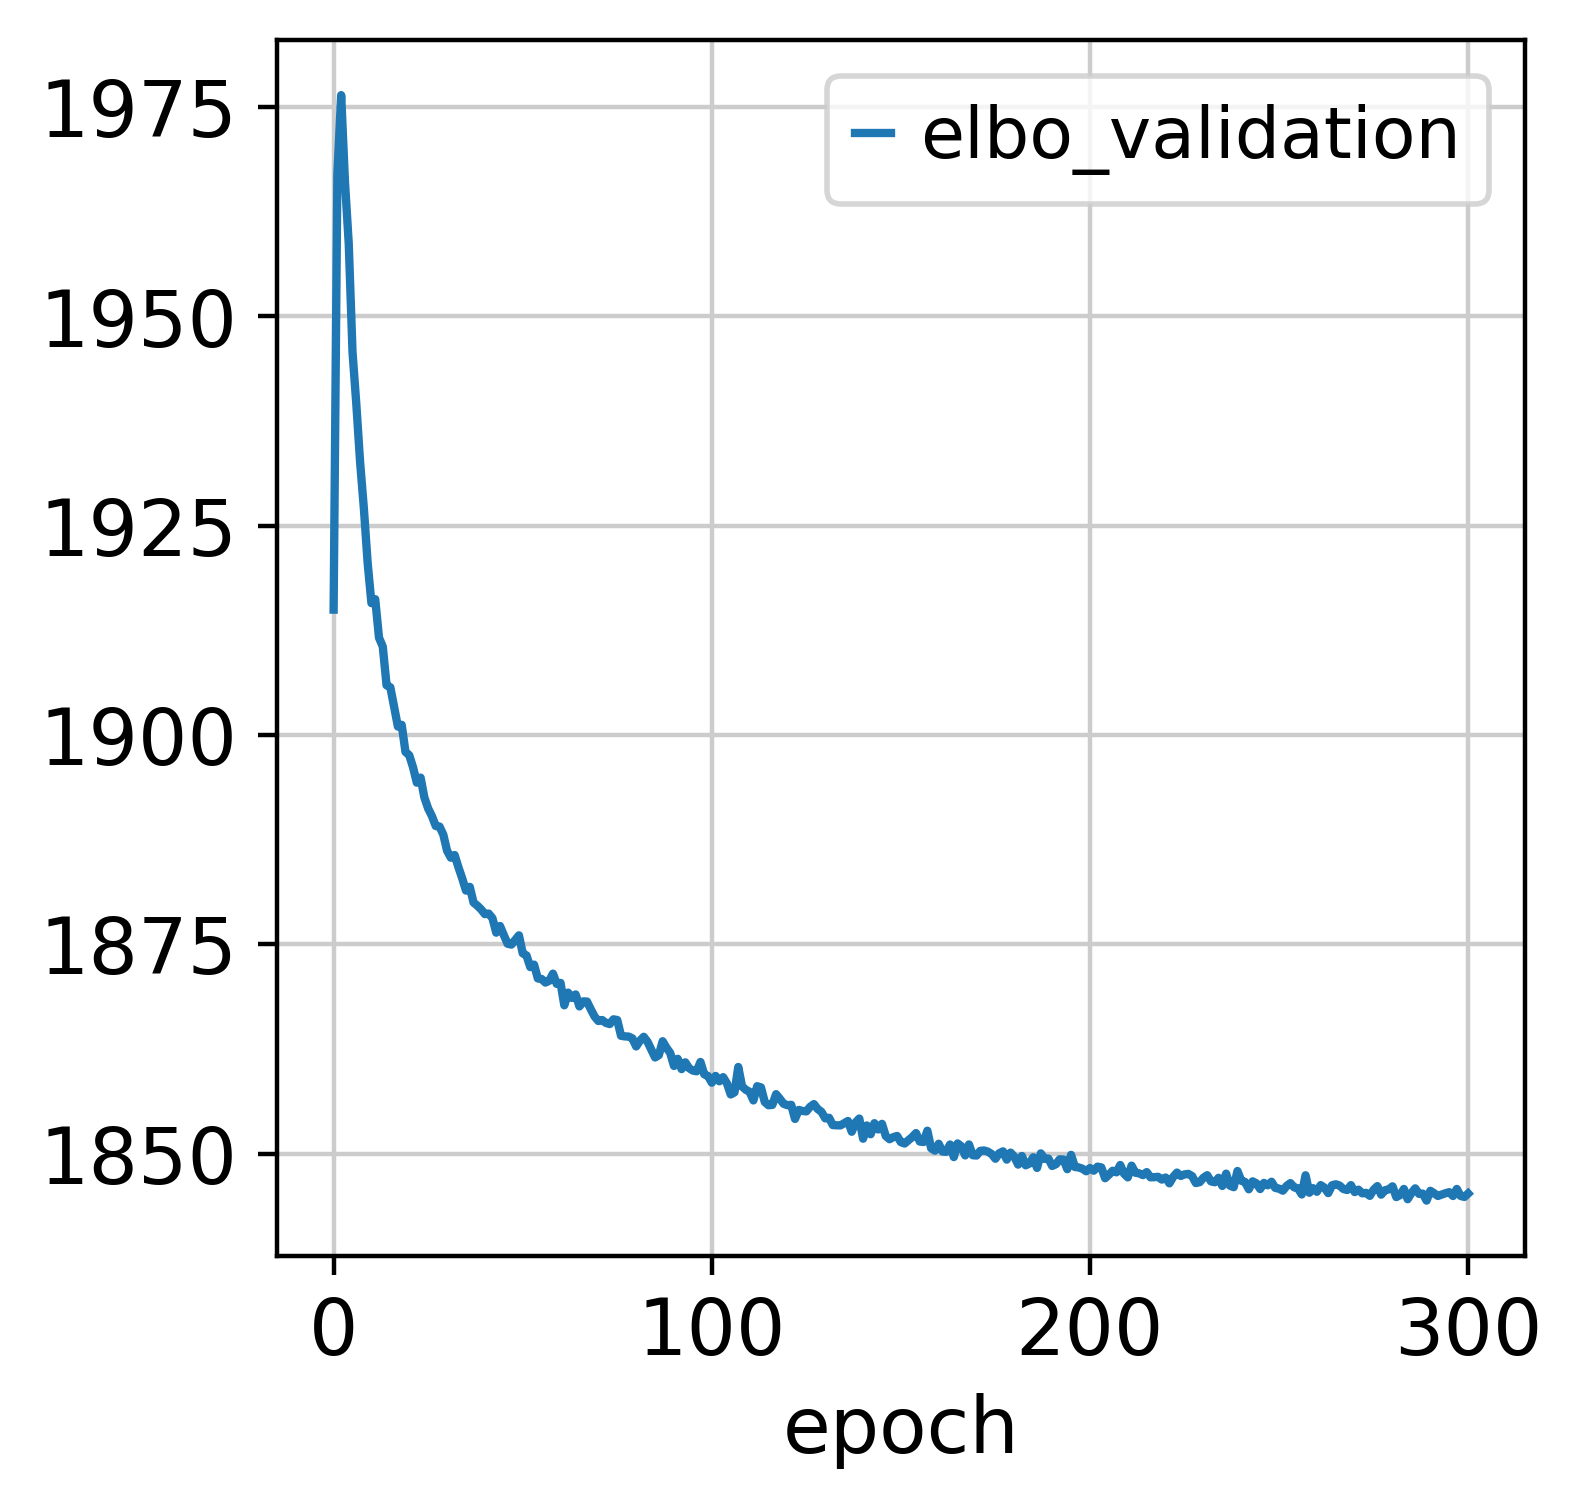

In [25]:
scanvi_model.history["elbo_validation"].plot()

In [26]:
SCANVI_LATENT_KEY = "X_scANVI"

ref_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

In [27]:
sc.pp.neighbors(
    adata = ref_adata, 
    use_rep = SCANVI_LATENT_KEY, 
    n_neighbors = 15,
    n_pcs = 50
)

sc.tl.leiden(
    ref_adata,
    flavor = "igraph",
    resolution = 1,
    n_iterations = 10
)

In [28]:
SCANVI_MDE_KEY = "X_scANVI_MDE"

ref_adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(ref_adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


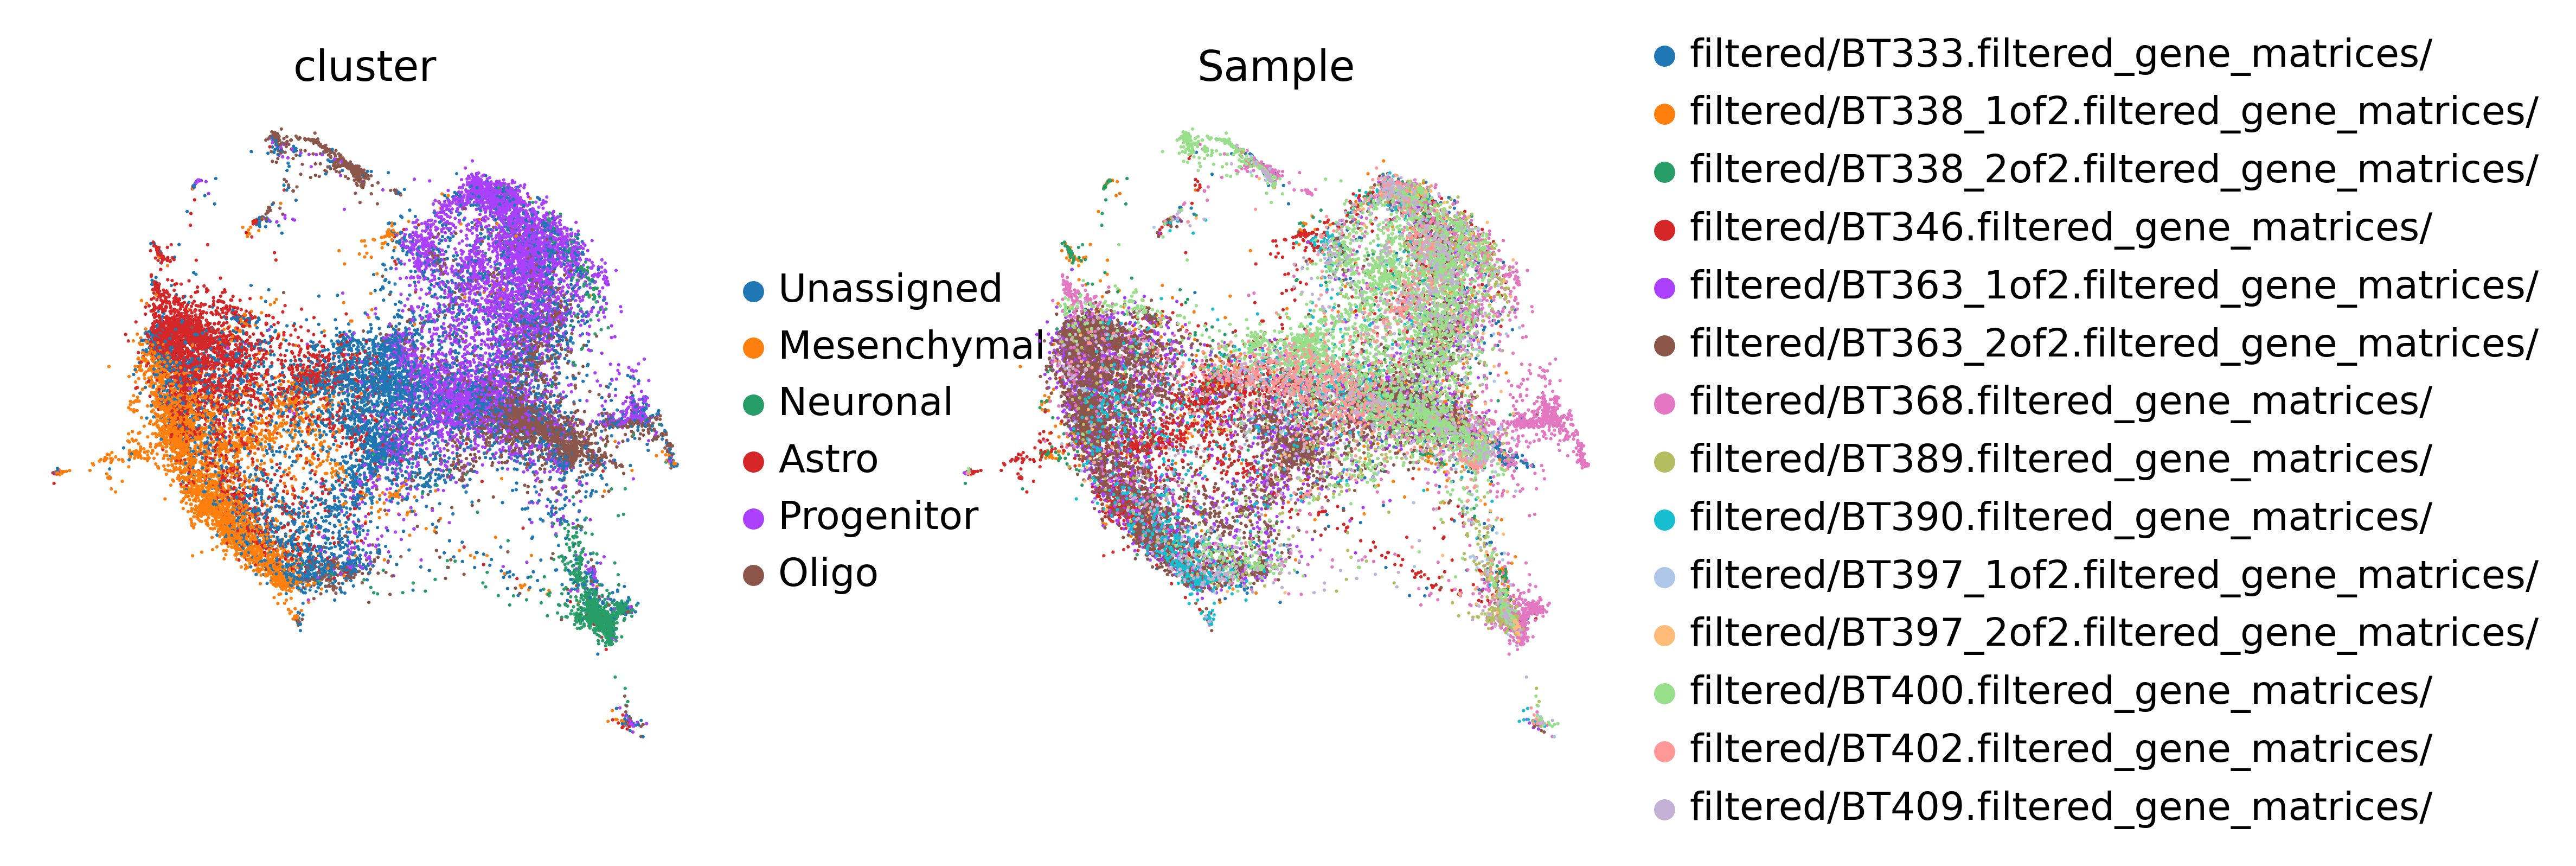

In [29]:
sc.pl.embedding(
    adata = ref_adata,
    basis = SCANVI_MDE_KEY,
    color = ["cluster", "Sample"],
    frameon = False,
    ncols = 2,
)

<Axes: xlabel='epoch'>

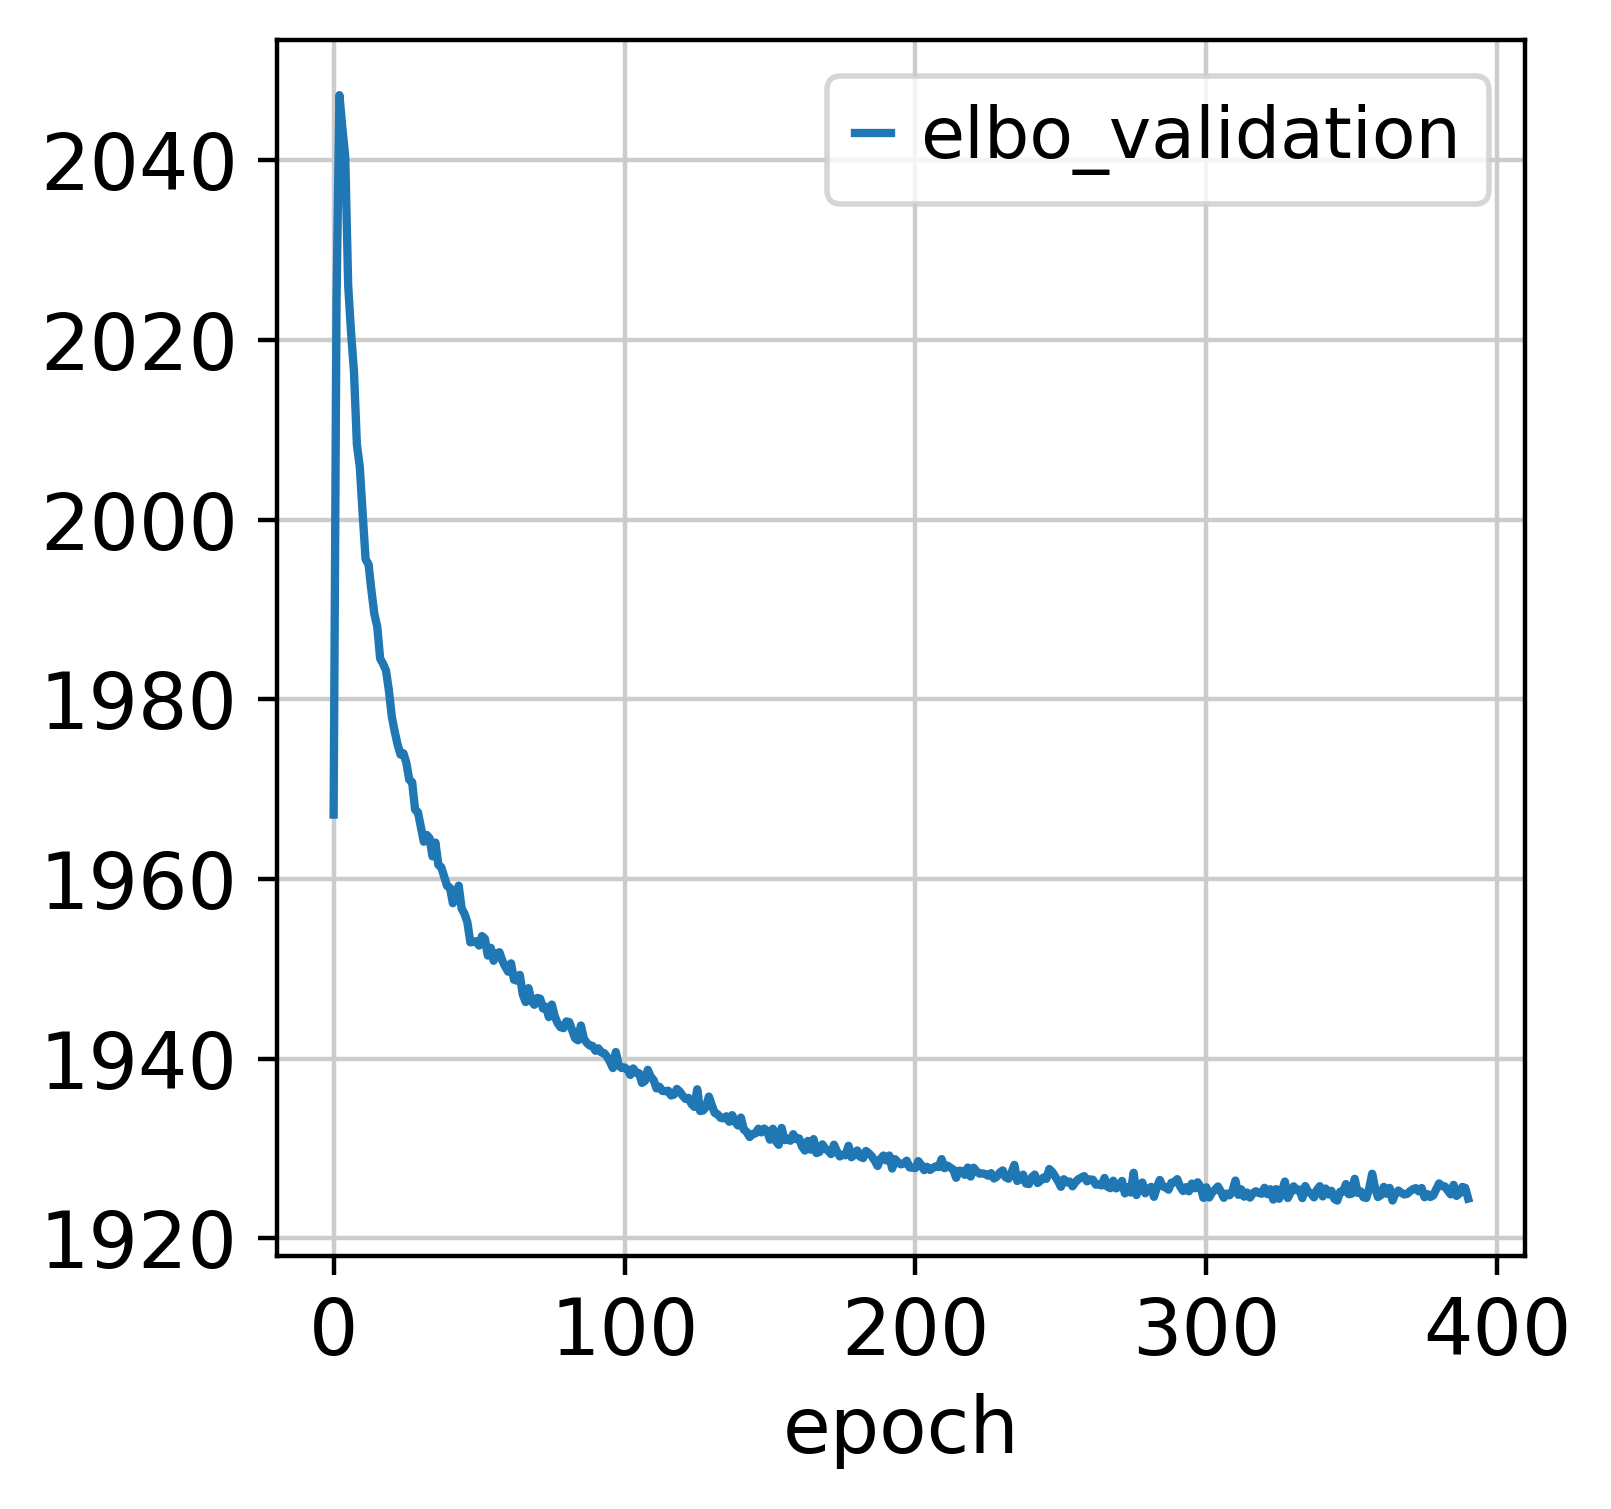

In [30]:
scanvi_model.history["elbo_validation"].plot()

In [35]:
scanvi_model.save(
    "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/models/scanvi", 
    overwrite = True
)

In [103]:
target_adata = sc.read("/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/2_1_scvi/GL0028_pre.h5ad")
target_adata.layers["counts"] = target_adata.X.copy()
target_adata

AnnData object with n_obs × n_vars = 6952 × 19463
    obs: 'bc_wells', 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'doublet_score', 'predicted_doublets', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'low_lib_size', 'low_n_features', 'high_subsets_mito_percent', 'discard', 'discard_mito', 'discard_feature', 'discard_final', 'sizeFactor', 'leiden_individual'
    var: 'gene_id', 'gene_name', 'genome', 'gene_version', 'gene_source', 'gene_biotype'
    uns: 'X_name'
    layers: 'logcounts', 'counts'

In [108]:
intersection = target_adata.var_names.intersection(ref_adata.var_names)

In [110]:
target_adata = target_adata[:, intersection].copy()

In [111]:
scvi.model.SCANVI.prepare_query_anndata(target_adata, scanvi_model)

INFO     Found 82.52000000000001% reference vars in query data.                                                    


In [112]:
target_adata.obs["cluster"] = scanvi_model.unlabeled_category_
target_adata.obs["Sample"] = "test"

In [113]:
scanvi_query = scvi.model.SCANVI.load_query_data(
    target_adata, 
    "/vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/models/scanvi"
)

INFO     File /vast/scratch/users/moore.z/pdo_pdn_comparison/data/processed/models/scanvi/model.pt already         
         downloaded                                                                                                


/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scvi/data/_manager.py:209: UserWarning: Missing labels key labels_scanvi. Filling in with unlabeled category unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [114]:
scanvi_query.train(
    max_epochs = 250,
    plan_kwargs = {"weight_decay": 0.0},
    early_stopping = True
)

INFO     Training for 250 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 240/250:  96%|█████████▌| 240/250 [03:13<00:08,  1.24it/s, v_num=1, train_loss_step=2.98e+3, train_loss_epoch=2.97e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 3129.081. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

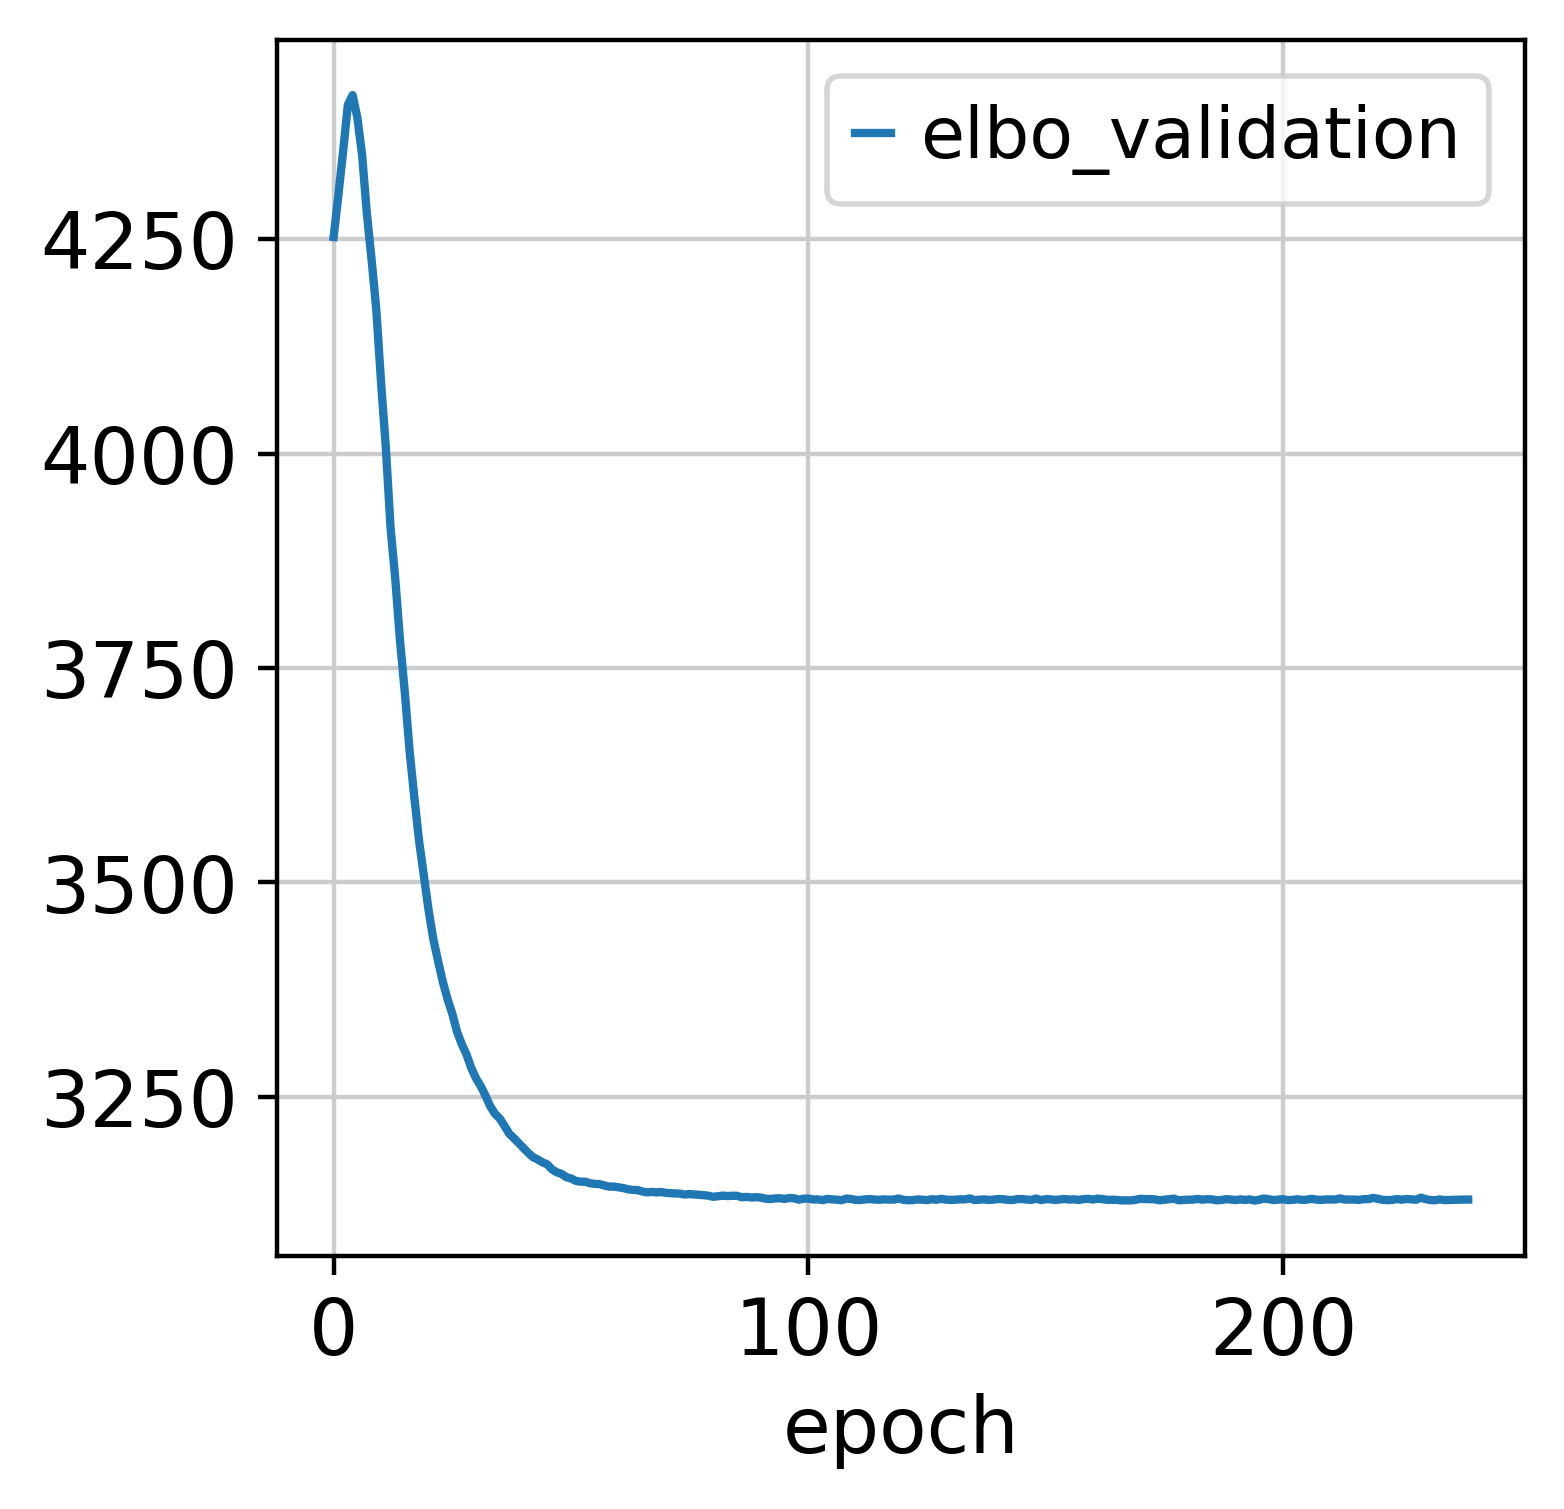

In [119]:
scanvi_query.history["elbo_validation"].plot()

In [120]:
SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

target_adata.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
target_adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

In [121]:
import anndata
full_adata = anndata.concat([target_adata, ref_adata], label = "batch")
full_adata

AnnData object with n_obs × n_vars = 24579 × 5000
    obs: 'cluster', 'Sample', '_scvi_batch', 'labels_scanvi', '_scvi_labels', 'batch'
    obsm: 'X_scANVI'
    layers: 'counts'

In [122]:
full_predictions = scanvi_query.predict(full_adata)
print(f"Acc: {np.mean(full_predictions == full_adata.obs['cluster'])}")

full_adata.obs[SCANVI_PREDICTIONS_KEY] = full_predictions

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Acc: 0.6903454168192359

In [123]:
full_adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(full_adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              
Jul 10 02:59:11 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jul 10 02:59:11 PM: The following items have duplicates [10397 10458 10503 10918 10960 11019 11037 11123 11144 11814 11819 13163
 13322 13853 13998 14125 14148 15043 15710 15819 15852]


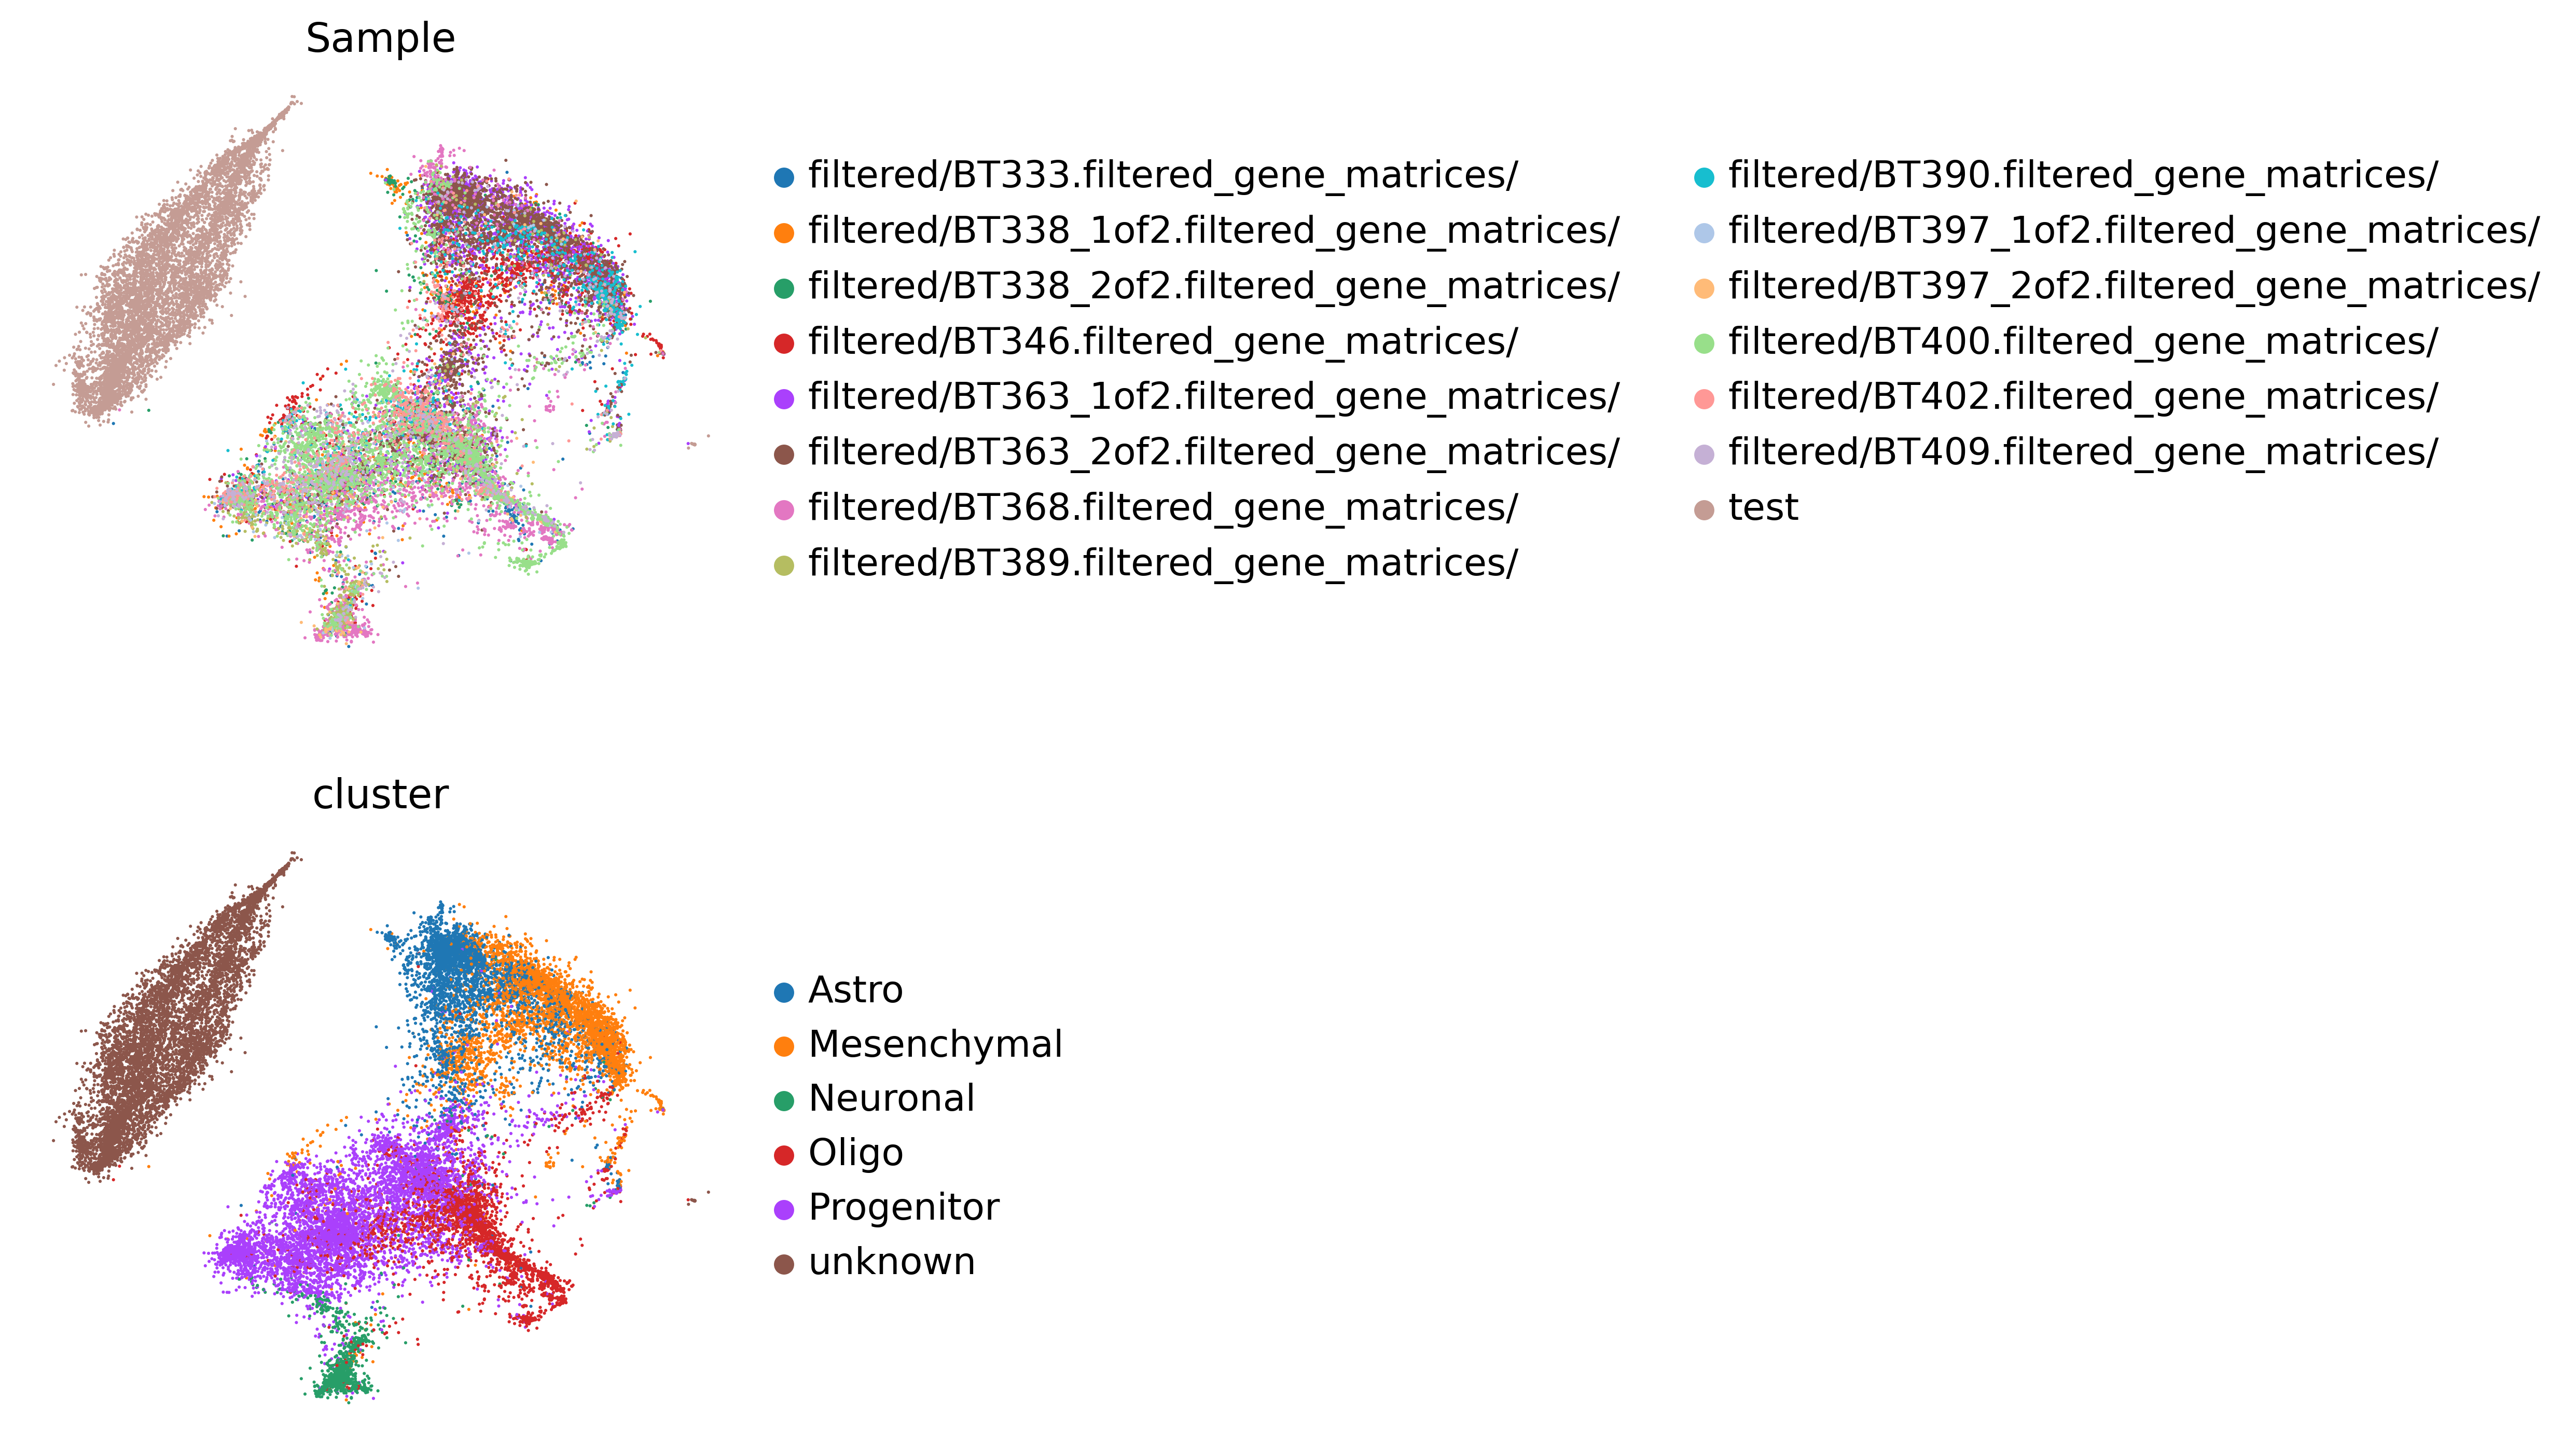

In [125]:
sc.pl.embedding(
    full_adata, 
    basis = SCANVI_MDE_KEY, 
    color = ["Sample", "cluster"], 
    ncols = 1, 
    frameon = False
)

/home/users/allstaff/moore.z/.conda/envs/scvi/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


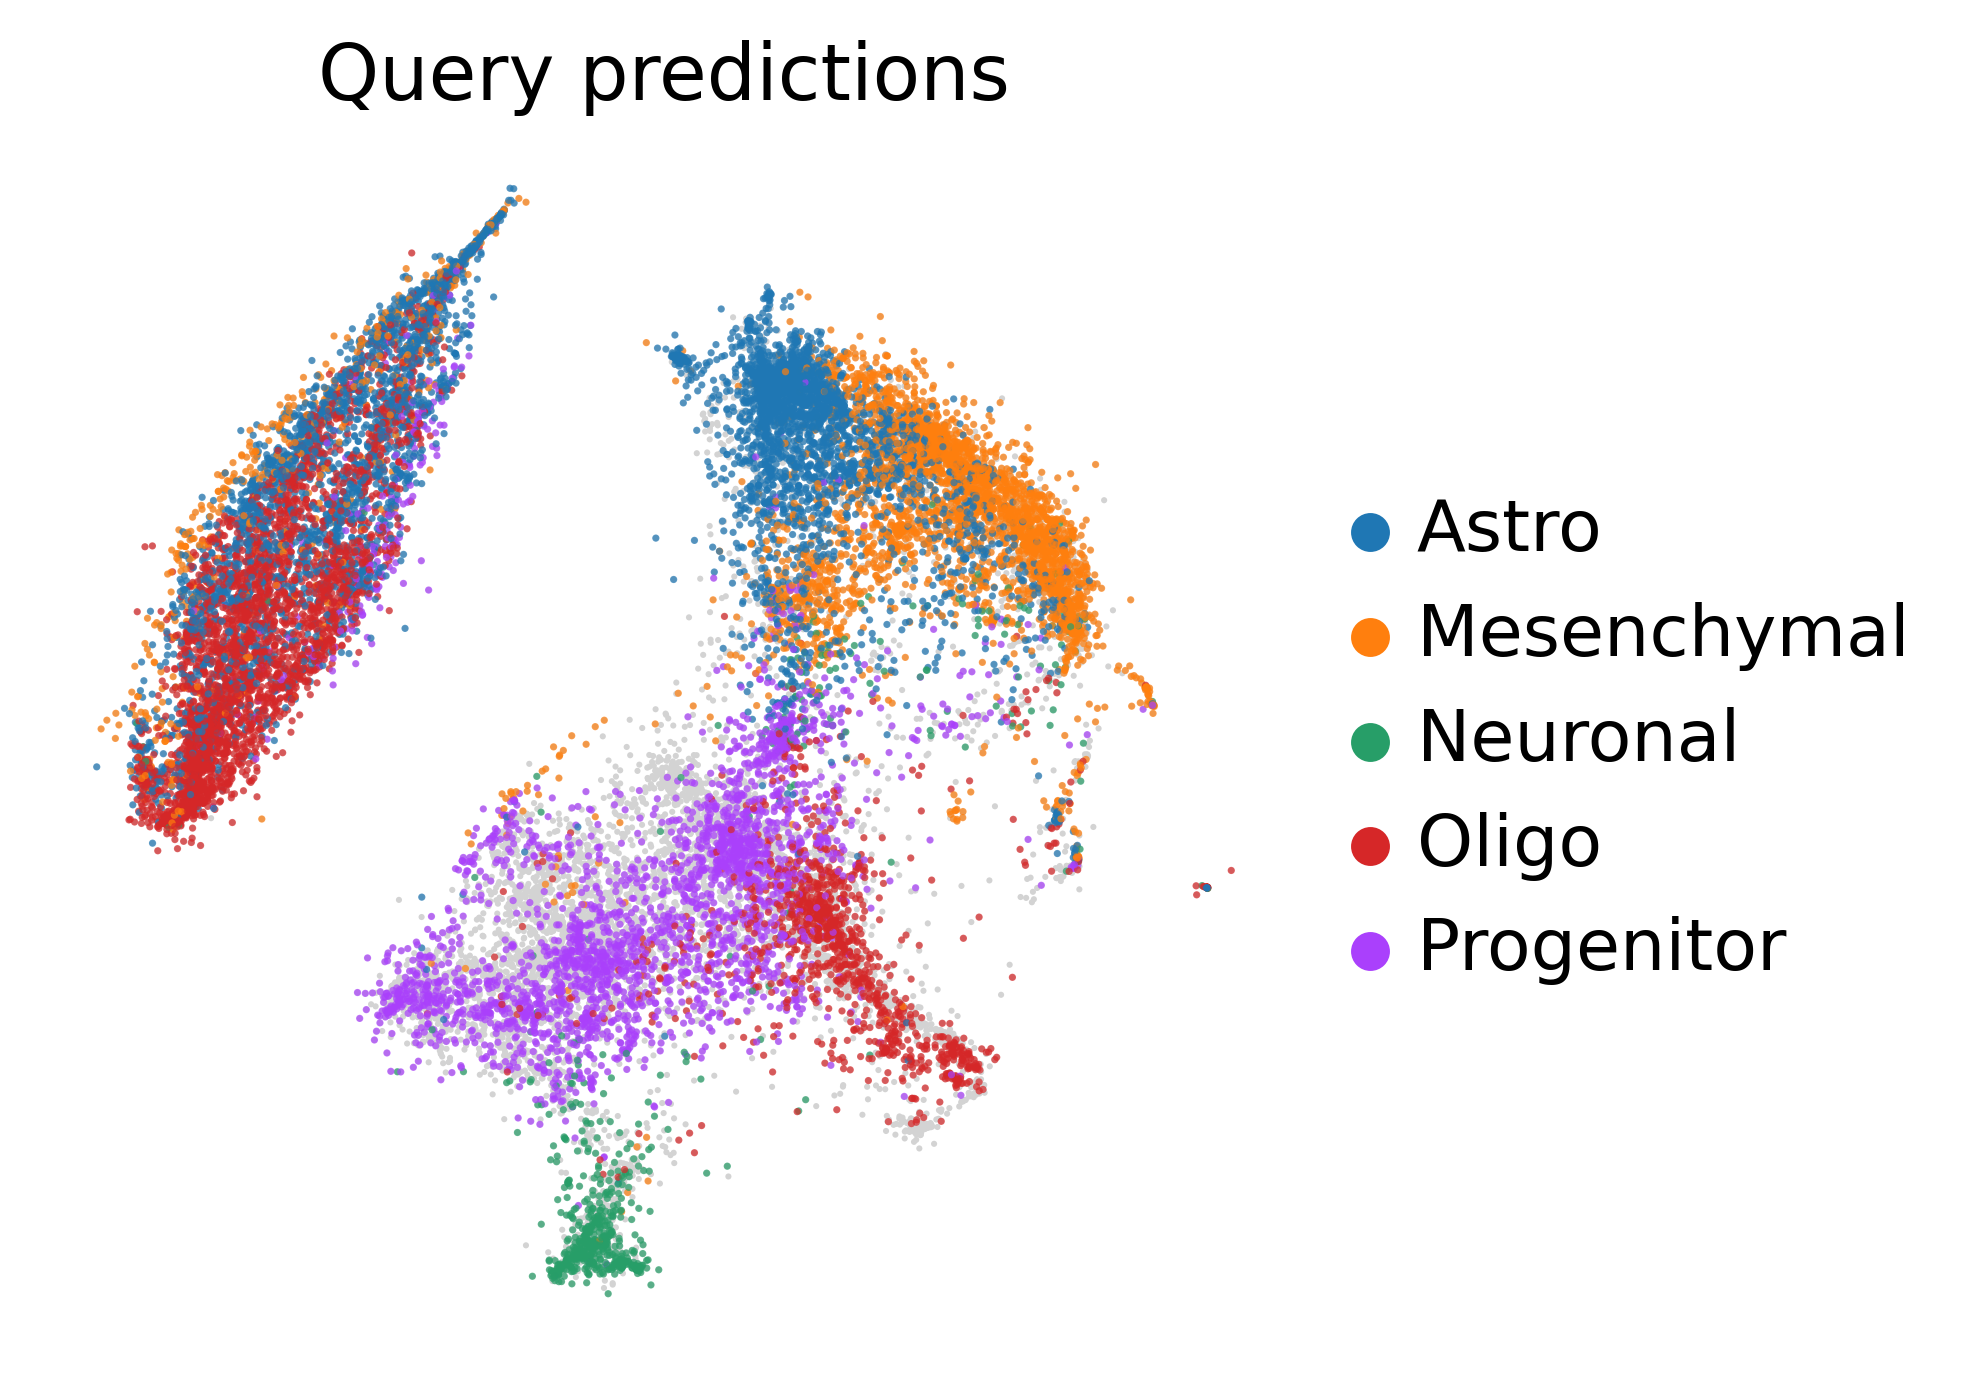

In [126]:
ax = sc.pl.embedding(
    full_adata,
    basis = SCANVI_MDE_KEY,
    frameon = False,
    show = False,
)
sc.pl.embedding(
    full_adata[: ref_adata.n_obs],
    basis = SCANVI_MDE_KEY,
    color = [SCANVI_PREDICTIONS_KEY],
    frameon = False,
    title = "Query predictions",
    ax = ax,
    alpha = 0.7,
)